In [1]:
import pandas as pd
from zipfile import ZipFile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [3]:
!pwd

/home/tielyr/Python2


In [4]:
"""
with ZipFile('/home/tielyr/Python2/forest-fire-prediction (1).zip', 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall( 
        path='/home/tielyr/Python2/forest-fire-prediction' )
        """

In [3]:
!ls

 Blackjack.ipynb        Lab5_TD.ipynb
 DATA3402.Spring.2024   Lab7_TD.ipynb
 FireKaggle.ipynb       Lab_3_TylerDixon.ipynb
 Lab.3-TD.ipynb         Lab_6_SecondCommit.ipynb
 Lab.3.ipynb	        Lectures
 Lab.4.ipynb	        TicTacToe.ipynb
 Lab.7.ipynb	        forest-fire-prediction
 Lab2_TD.ipynb	       'forest-fire-prediction (1).zip'
 Lab2work.ipynb         lab3notes.ipynb
 Lab4_TD.ipynb	        lab7TD_pt2.ipynb
 Lab4_TDixon.ipynb


In [4]:
os.chdir('/home/tielyr/Python2/forest-fire-prediction')
!pwd

/home/tielyr/Python2/forest-fire-prediction


# Data Understanding

The kaggle site does not tell me what the acronyms stand for. From a brief search, Fire Weather Indices (FWI) seem to be uniform among cities, states, and countries. This was the first guide to the acronym meanings I found:
https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

**Fine Fuel Moisture Code (FFMC)**
-a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

**Duff Moisture Code(DMC)**
-a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.


**Drought Code(DC)**
-a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.


**Initial Spread Index(ISI)**
-a numeric rating of the expected rate of fire spread. It is based on wind speed and FFMC. Like the rest of the FWI system components, ISI does not take fuel type into account. Actual spread rates vary between fuel types at the same ISI.


**Buildup Index(BUI)**
-a numeric rating of the total amount of fuel available for combustion. It is based on the DMC and the DC. The BUI is generally less than twice the DMC value, and moisture in the DMC layer is expected to help prevent burning in material deeper down in the available fuel.


**Fire Weather Index(FWI)**
-a numeric rating of fire intensity. It is based on the ISI and the BUI, and is used as a general index of fire danger throughout the forested areas of Canada.



*I can also only assume that for the Classes, 1.0 means there was a fire and 0.0 means there wasn't*

In [5]:
train = pd.read_csv('train.csv')

In [246]:
train.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,6,7,2012,35,42,15,0.3,84.7,15.5,45.1,4.3,16.7,6.3,1.0
1,12,8,2012,35,51,13,0.3,81.3,15.6,75.1,2.5,20.7,4.2,0.0
2,27,6,2012,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1.0
3,18,7,2012,31,68,14,0.0,85.4,12.1,43.1,4.6,14.2,6.0,1.0
4,25,7,2012,39,64,9,1.2,73.8,11.7,15.9,1.1,11.4,0.7,0.0


In [247]:
print('\nShape:', train.shape, '\n\nInfo:\n')
print(train.info())
print('\nDescribe:\n', train.describe())



Shape: (196, 14) 

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          196 non-null    int64  
 1   month        196 non-null    int64  
 2   year         196 non-null    int64  
 3   Temperature  196 non-null    int64  
 4    RH          196 non-null    int64  
 5    Ws          196 non-null    int64  
 6   Rain         196 non-null    float64
 7   FFMC         196 non-null    float64
 8   DMC          196 non-null    float64
 9   DC           196 non-null    object 
 10  ISI          196 non-null    float64
 11  BUI          196 non-null    float64
 12  FWI          196 non-null    float64
 13  Classes      195 non-null    float64
dtypes: float64(7), int64(6), object(1)
memory usage: 21.6+ KB
None

Describe:
               day       month    year  Temperature          RH          Ws  \
count  196.000000  196.000000   196.0 

In [248]:
np.where(train.duplicated())

(array([], dtype=int64),)

In [6]:
np.where(pd.isnull(train))

(array([107]), array([13]))

In [250]:
train.iloc[107]  #has no class identifier, should delete the whole row since it can't be used for prediction. 

day                14
month               7
year             2012
Temperature        37
 RH                37
 Ws                18
Rain              0.2
FFMC             88.9
DMC              12.9
DC             14.6 9
ISI              12.5
BUI              10.4
FWI               1.0
Classes           NaN
Name: 107, dtype: object

In [7]:
train.dropna(axis = 0, inplace = True)
np.where(pd.isnull(train))
#done!

(array([], dtype=int64), array([], dtype=int64))

In [17]:
train.query('day == 0').index
train.query('month == 0').index
train.query('year == 0').index
train.query('day < 0').index
train.query('month < 0').index
train.query('year < 0').index

Index([], dtype='int64')

In [18]:
set(train.iloc[:,2]) #the year is the same for every entry, so maybe this columns could be dropped

{2012}

In [19]:
set(train.iloc[:,1]) #only 4 months were sampled- june, july, august, and september. All summer weather mostly, but there could be seasonal variation
#but it could totally be one-hot encoded. 
#I'm not sure if the day has a ton of merit.... but theres no way to tell. Not sure if It should be binned or left alone

{6, 7, 8, 9}

# Preliminary Visualization

In [252]:
train.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,6,7,2012,35,42,15,0.3,84.7,15.5,45.1,4.3,16.7,6.3,1.0
1,12,8,2012,35,51,13,0.3,81.3,15.6,75.1,2.5,20.7,4.2,0.0
2,27,6,2012,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1.0
3,18,7,2012,31,68,14,0.0,85.4,12.1,43.1,4.6,14.2,6.0,1.0
4,25,7,2012,39,64,9,1.2,73.8,11.7,15.9,1.1,11.4,0.7,0.0


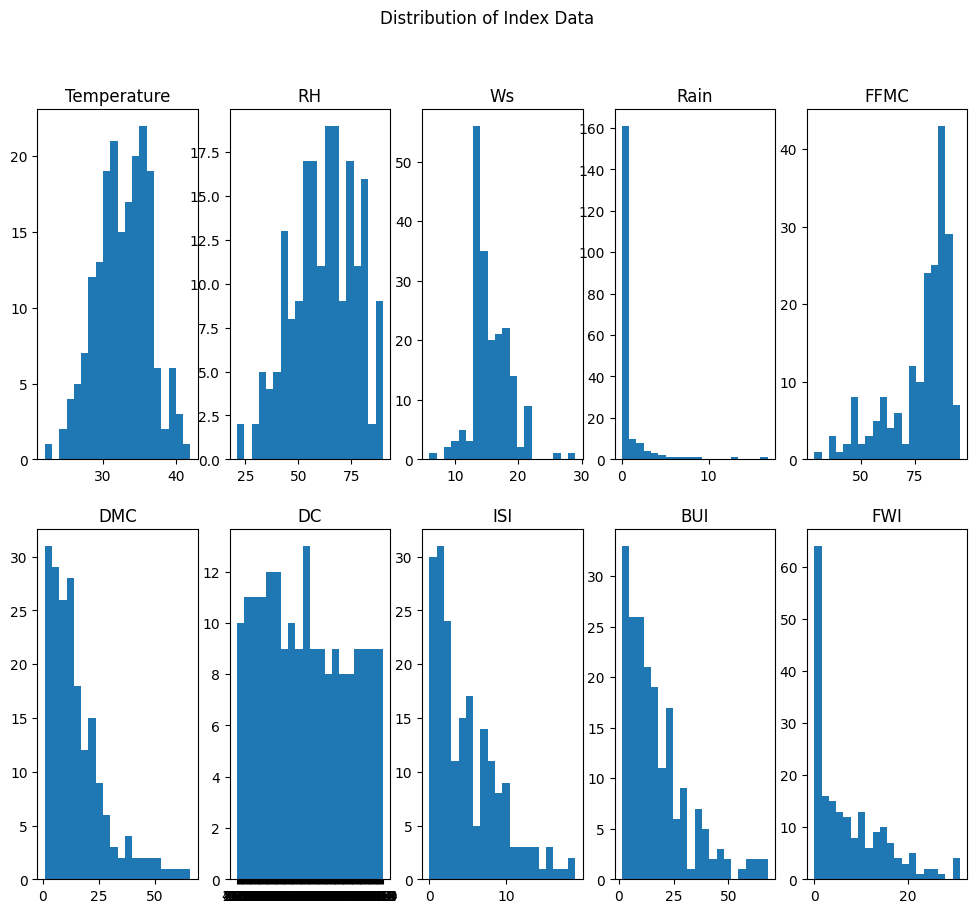

In [253]:
fig, prelims = plt.subplots(2,5, figsize = (12,10))
fig.suptitle('Distribution of Index Data')
prelims[0,0].hist(train.iloc[:,3], bins = 20)
prelims[0,0].set_title('Temperature')
prelims[0,1].hist(train.iloc[:,4], bins = 20)
prelims[0,1].set_title('RH')
prelims[0,2].hist(train.iloc[:,5], bins = 20)
prelims[0,2].set_title('Ws')
prelims[0,3].hist(train.iloc[:,6], bins = 20)
prelims[0,3].set_title('Rain')
prelims[0,4].hist(train.iloc[:,7], bins = 20)
prelims[0,4].set_title('FFMC')
prelims[1,0].hist(train.iloc[:,8], bins = 20)
prelims[1,0].set_title('DMC')
prelims[1,1].hist(train.iloc[:,9], bins = 20)
prelims[1,1].set_title('DC')
prelims[1,2].hist(train.iloc[:,10], bins = 20)
prelims[1,2].set_title('ISI')
prelims[1,3].hist(train.iloc[:,11], bins = 20)
prelims[1,3].set_title('BUI')
prelims[1,4].hist(train.iloc[:,12], bins = 20)
prelims[1,4].set_title('FWI')

plt.savefig('prelim.png')


Data is not normal and mostly skewed. No linear regression. I won't normalize anything either so I'll need to use an algorithm that is robust to outliers and non normal data.

In [11]:
train.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

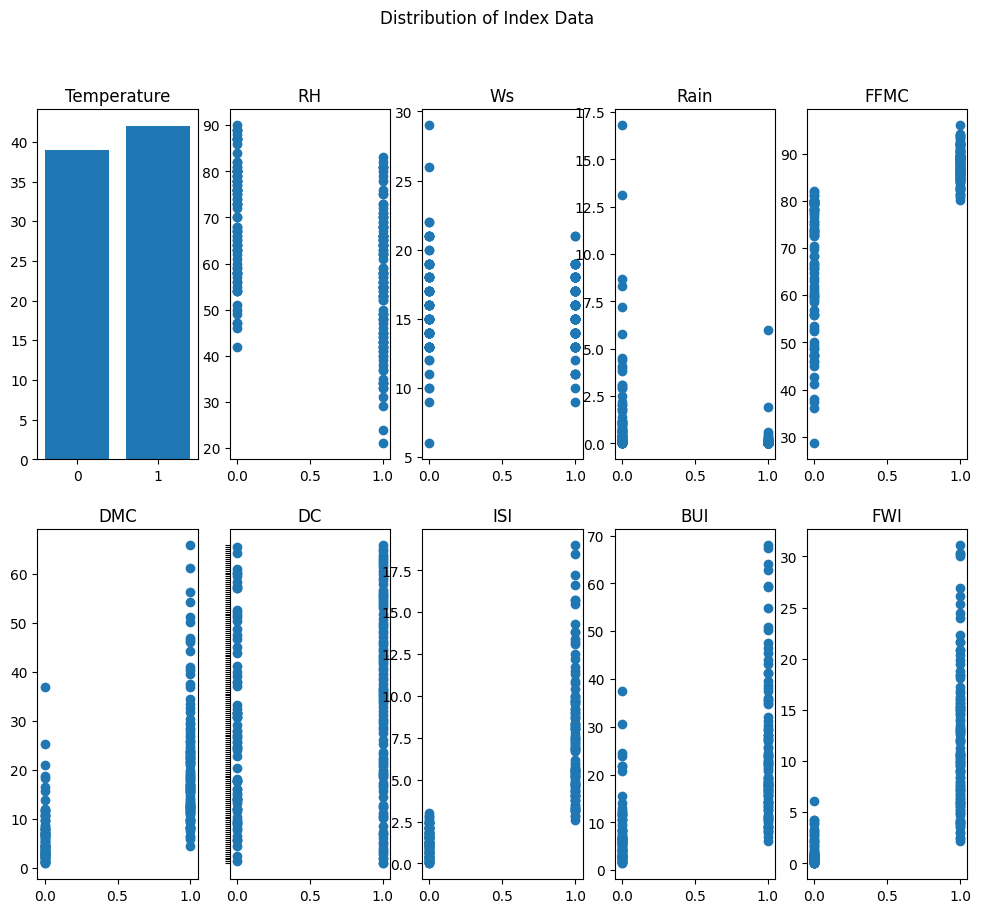

In [26]:
fig, cat = plt.subplots(2,5, figsize = (12,10))
fig.suptitle('Distribution of Index Data')
cat[0,0].bar(train['Classes  '], train['Temperature'])
cat[0,0].set_title('Temperature')
cat[0,1].scatter(train['Classes  '], train[' RH'])
cat[0,1].set_title('RH')
cat[0,2].scatter(train['Classes  '], train[' Ws'])
cat[0,2].set_title('Ws')
cat[0,3].scatter(train['Classes  '], train['Rain '])
cat[0,3].set_title('Rain')
cat[0,4].scatter(train['Classes  '], train['FFMC'])
cat[0,4].set_title('FFMC')
cat[1,0].scatter(train['Classes  '], train['DMC'])
cat[1,0].set_title('DMC')
cat[1,1].scatter(train['Classes  '], train['DC'])
cat[1,1].set(yticklabels=[])
cat[1,1].set_title('DC')
cat[1,2].scatter(train['Classes  '], train['ISI'])
cat[1,2].set_title('ISI')
cat[1,3].scatter(train['Classes  '], train['BUI'])
cat[1,3].set_title('BUI')
cat[1,4].scatter(train['Classes  '], train['FWI'])
cat[1,4].set_title('FWI')

plt.savefig('cat.png')




In [18]:
#try grouping these by month, day, then the classes themselves?
monthtemp = train.groupby('month')['Temperature'].mean()
monthtemp
#dates are categorical for this dataset although still numerical in data type

month
6    30.620000
7    33.000000
8    35.549020
9    29.243902
Name: Temperature, dtype: float64

In [19]:
month_rain =  train.groupby('month')['Rain '].mean()
month_rain

month
6    0.956000
7    0.437736
8    0.521569
9    1.114634
Name: Rain , dtype: float64

In [20]:
june = train[train['month'] == 6]
july = train[train['month'] == 7]
august = train[train['month'] == 8]
september = train[train['month'] == 9]

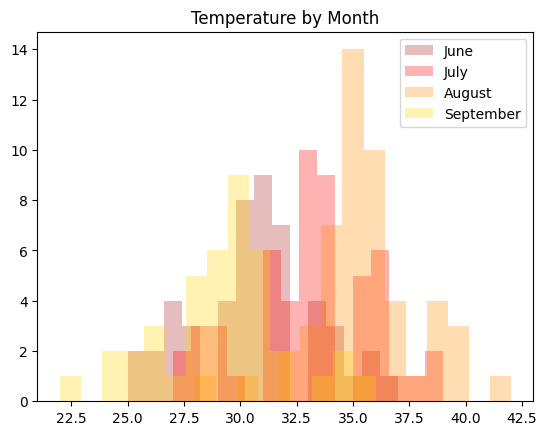

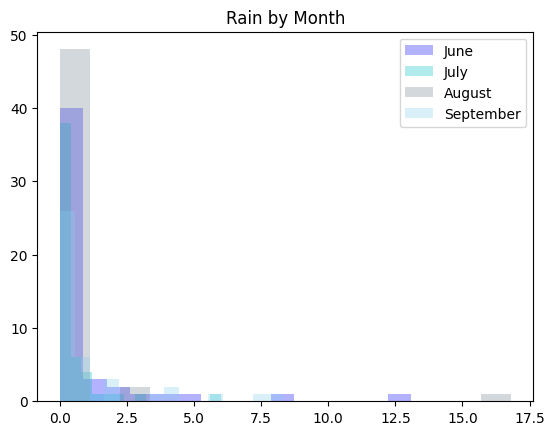

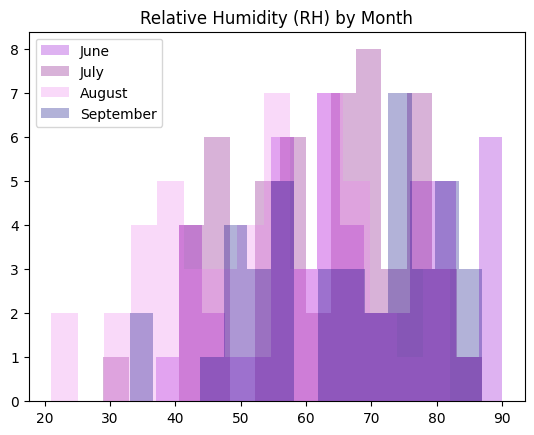

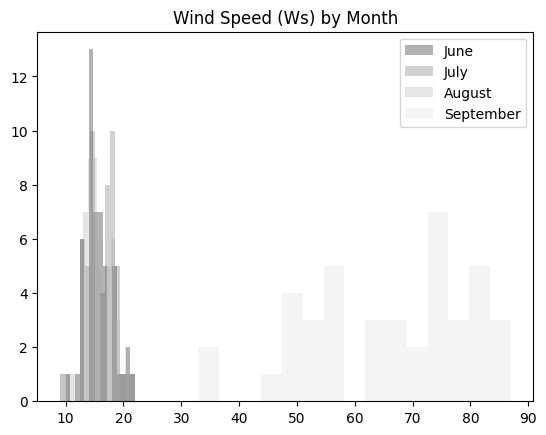

In [21]:
_= plt.hist(june.iloc[:,3], bins = 15, alpha = 0.3, color= 'firebrick',label = 'June' )
_=plt.hist(july.iloc[:,3], bins=15, alpha = 0.3, color= 'red',label = 'July' )
_=plt.hist(august.iloc[:,3], bins=15, alpha = 0.3, color= 'darkorange',label = 'August' )
_=plt.hist(september.iloc[:,3], bins=15, alpha = 0.3, color= 'gold',label = 'September' )
_= plt.legend()
plt.title('Temperature by Month')
plt.show()


_= plt.hist(june.iloc[:,6], bins = 15, alpha = 0.3, color= 'b',label = 'June' )
_=plt.hist(july.iloc[:,6], bins=15, alpha = 0.3, color= 'c',label = 'July' )
_=plt.hist(august.iloc[:,6], bins=15, alpha = 0.3, color= 'slategrey',label = 'August' )
_=plt.hist(september.iloc[:,6], bins=15, alpha = 0.3, color= 'skyblue',label = 'September' )
_= plt.legend()
plt.title('Rain by Month')
plt.show()

_= plt.hist(june.iloc[:,4], bins = 15, alpha = 0.3, color= 'darkviolet',label = 'June' )
_=plt.hist(july.iloc[:,4], bins=15, alpha = 0.3, color= 'purple',label = 'July' )
_=plt.hist(august.iloc[:,4], bins=15, alpha = 0.3, color= 'violet',label = 'August' )
_=plt.hist(september.iloc[:,4], bins=15, alpha = 0.3, color= 'navy',label = 'September' )
_= plt.legend()
plt.title('Relative Humidity (RH) by Month')
plt.show()

_= plt.hist(june.iloc[:,5], bins = 15, alpha = 0.3, color= 'black',label = 'June' )
_=plt.hist(july.iloc[:,5], bins=15, alpha = 0.3, color= 'dimgrey',label = 'July' )
_=plt.hist(august.iloc[:,5], bins=15, alpha = 0.3, color= 'darkgrey',label = 'August' )
_=plt.hist(september.iloc[:,4], bins=15, alpha = 0.3, color= 'gainsboro',label = 'September' )
_= plt.legend()
plt.title('Wind Speed (Ws) by Month')
plt.show()


It's obvious that the months have a large impact on the data. There are no unecessarily extreme outliers (which would suggest bad input or improper units) to remove or any more null values. I'll do some data conversion like converting the classes to integer and DC to float. Then I'll drop the year column, encode the month, possibly try it without the day and then run the model again with the day to see if that makes a difference. Then I'll robustly scale the data because of the outliers, then pick a model. 

In [22]:
train.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,6,7,2012,35,42,15,0.3,84.7,15.5,45.1,4.3,16.7,6.3,1.0
1,12,8,2012,35,51,13,0.3,81.3,15.6,75.1,2.5,20.7,4.2,0.0
2,27,6,2012,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1.0
3,18,7,2012,31,68,14,0.0,85.4,12.1,43.1,4.6,14.2,6.0,1.0
4,25,7,2012,39,64,9,1.2,73.8,11.7,15.9,1.1,11.4,0.7,0.0


In [21]:
train.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

In [22]:
set(train.iloc[:,-1]) #making sure those are really the only values

{0.0, 1.0}

In [28]:
train['DC'] = pd.to_numeric(train['DC'], errors = 'coerce')

In [24]:
train['Classes  '] = pd.to_numeric(train['Classes  '], errors='coerce', downcast='integer')

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 0 to 195
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          195 non-null    int64  
 1   month        195 non-null    int64  
 2   year         195 non-null    int64  
 3   Temperature  195 non-null    int64  
 4    RH          195 non-null    int64  
 5    Ws          195 non-null    int64  
 6   Rain         195 non-null    float64
 7   FFMC         195 non-null    float64
 8   DMC          195 non-null    float64
 9   DC           195 non-null    float64
 10  ISI          195 non-null    float64
 11  BUI          195 non-null    float64
 12  FWI          195 non-null    float64
 13  Classes      195 non-null    int8   
dtypes: float64(7), int64(6), int8(1)
memory usage: 21.5 KB


In [30]:
train.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

In [31]:
#encoding the months
train = pd.get_dummies(train, columns=['month'], dtype = int)
train.head()

,day,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,month_6,month_7,month_8,month_9
0,6,2012,35,42,15,0.3,84.7,15.5,45.1,4.3,16.7,6.3,1,0,1,0,0
1,12,2012,35,51,13,0.3,81.3,15.6,75.1,2.5,20.7,4.2,0,0,0,1,0
2,27,2012,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1,1,0,0,0
3,18,2012,31,68,14,0.0,85.4,12.1,43.1,4.6,14.2,6.0,1,0,1,0,0
4,25,2012,39,64,9,1.2,73.8,11.7,15.9,1.1,11.4,0.7,0,0,1,0,0


In [ ]:
#the day is interesting because it is categorical, but one hot encoding would be too many added columns, this could be considered label encoding as-is,
#but will the model read the information wrong? Will test in model runs with the two different datasets. 

In [38]:
class_col = train.pop('Classes  ')
train.insert(16, 'Classes  ', class_col)
train.head()

,day,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,month_6,month_7,month_8,month_9,Classes
0,6,2012,35,42,15,0.3,84.7,15.5,45.1,4.3,16.7,6.3,0,1,0,0,1
1,12,2012,35,51,13,0.3,81.3,15.6,75.1,2.5,20.7,4.2,0,0,1,0,0
2,27,2012,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1,0,0,0,1
3,18,2012,31,68,14,0.0,85.4,12.1,43.1,4.6,14.2,6.0,0,1,0,0,1
4,25,2012,39,64,9,1.2,73.8,11.7,15.9,1.1,11.4,0.7,0,1,0,0,0


In [39]:
train.drop(['year'], axis = 1, inplace = True)

In [40]:
train_nd = train.iloc[:,1:16] #the one without  the day

In [41]:
scaler = RobustScaler()
scaled_train = scaler.fit_transform(train)
scaled_train_nd = scaler.fit_transform(train_nd)

In [49]:
s_train = pd.DataFrame(scaled_train)
s_train[15] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train[14] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train[13] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train[12] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train[11] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.666667,0.6,-1.000000,0.000000,0.75,0.045752,0.238095,0.166524,0.083333,0.211765,0.123348,0,0,0,0,0
1,-0.266667,0.6,-0.571429,-0.571429,0.75,-0.176471,0.244898,0.681545,-0.216667,0.447059,-0.061674,-1,-1,-1,-1,-1
2,0.733333,0.4,-0.476190,0.857143,0.00,0.326797,0.653061,0.770815,0.900000,0.747059,0.889868,0,0,0,0,0
3,0.133333,-0.2,0.238095,-0.285714,0.00,0.091503,0.006803,0.132189,0.133333,0.064706,0.096916,0,0,0,0,0
4,0.600000,1.4,0.047619,-1.714286,3.00,-0.666667,-0.020408,-0.334764,-0.450000,-0.100000,-0.370044,-1,-1,-1,-1,-1


In [50]:
s_train_nd = pd.DataFrame(scaled_train_nd)
s_train_nd[14] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train_nd[13] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train_nd[12] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train_nd[11] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train_nd[10] = pd.to_numeric(s_train[15], errors='coerce', downcast='integer')
s_train_nd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.6,-1.000000,0.000000,0.75,0.045752,0.238095,0.166524,0.083333,0.211765,0.123348,0,0,0,0,0
1,0.6,-0.571429,-0.571429,0.75,-0.176471,0.244898,0.681545,-0.216667,0.447059,-0.061674,-1,-1,-1,-1,-1
2,0.4,-0.476190,0.857143,0.00,0.326797,0.653061,0.770815,0.900000,0.747059,0.889868,0,0,0,0,0
3,-0.2,0.238095,-0.285714,0.00,0.091503,0.006803,0.132189,0.133333,0.064706,0.096916,0,0,0,0,0
4,1.4,0.047619,-1.714286,3.00,-0.666667,-0.020408,-0.334764,-0.450000,-0.100000,-0.370044,-1,-1,-1,-1,-1


Text(0.5, 1.0, 'FWI')

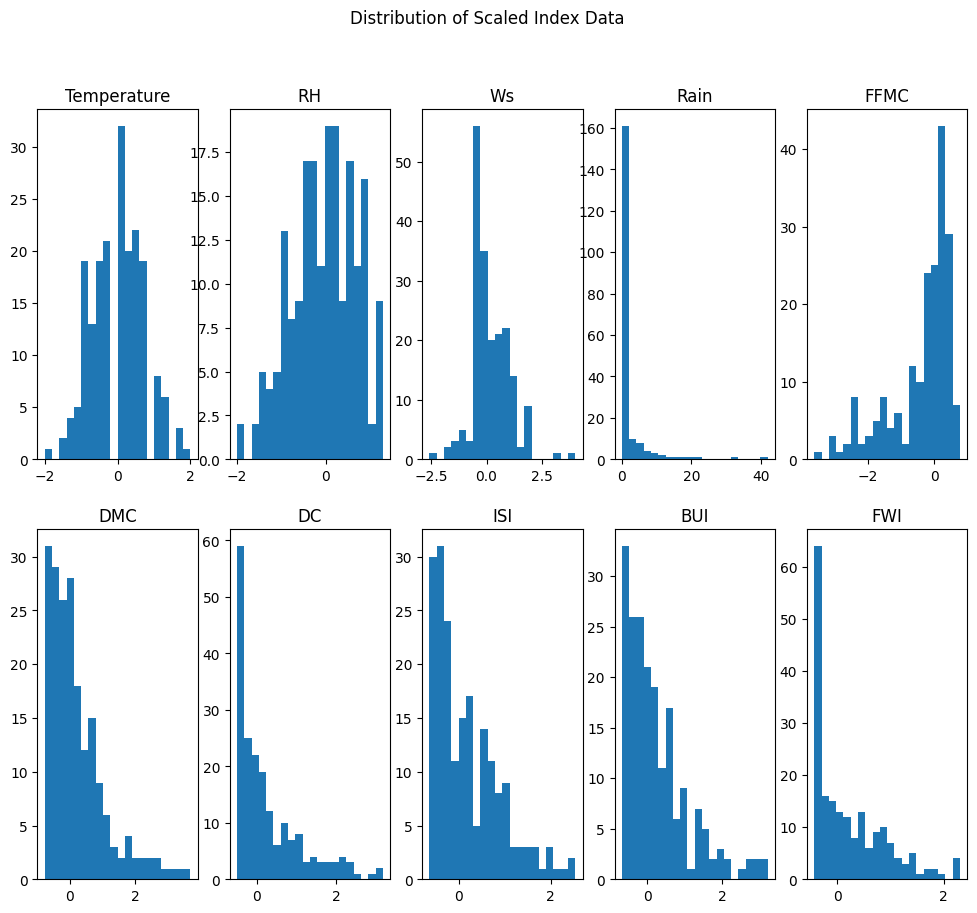

In [173]:
fig, scaled = plt.subplots(2,5, figsize = (12,10))
fig.suptitle('Distribution of Scaled Index Data')
scaled[0,0].hist(s_train.iloc[:,1], bins = 20)
scaled[0,0].set_title('Temperature')
scaled[0,1].hist(s_train.iloc[:,2], bins = 20)
scaled[0,1].set_title('RH')
scaled[0,2].hist(s_train.iloc[:,3], bins = 20)
scaled[0,2].set_title('Ws')
scaled[0,3].hist(s_train.iloc[:,4], bins = 20)
scaled[0,3].set_title('Rain')
scaled[0,4].hist(s_train.iloc[:,5], bins = 20)
scaled[0,4].set_title('FFMC')
scaled[1,0].hist(s_train.iloc[:,6], bins = 20)
scaled[1,0].set_title('DMC')
scaled[1,1].hist(s_train.iloc[:,7], bins = 20)
scaled[1,1].set_title('DC')
scaled[1,2].hist(s_train.iloc[:,8], bins = 20)
scaled[1,2].set_title('ISI')
scaled[1,3].hist(s_train.iloc[:,9], bins = 20)
scaled[1,3].set_title('BUI')
scaled[1,4].hist(s_train.iloc[:,10], bins = 20)
scaled[1,4].set_title('FWI')


Scaling changed some of the distributions quite a bit, like DC

# Choosing a model

Probably not a regression, considering the data does not follow a normal curve. I'm going to start with random forest and SVM 

First the original set without the day

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = train_nd.iloc[:,0:14] 
X.head()

y = train_nd.iloc[:,14]
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [152]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [153]:
y_pred = rf.predict(X_test)

In [156]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


High accuracy achieved without scaling- lets try adding the day

In [157]:
Xd = train.iloc[:,0:15]
Xd.head()

yd = train.iloc[:,15]
yd.head()
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.2)

In [158]:
rfd = RandomForestClassifier()
rfd.fit(Xd_train, yd_train)

RandomForestClassifier()

In [159]:
yd_pred = rfd.predict(Xd_test)

In [160]:
accuracy_d = accuracy_score(yd_test, yd_pred)
print("Accuracy:", accuracy_d)

Accuracy: 0.9743589743589743


**Adding the day got 100% accuracy. Is overfitting occurring? Trying the scaled data**

In [161]:
Xs = s_train.iloc[:,0:15]
Xs.head()

ys = s_train.iloc[:,15]
ys.head()
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2)

In [162]:
rfs = RandomForestClassifier()
rfs.fit(Xs_train, ys_train)

RandomForestClassifier()

In [163]:
ys_pred = rfs.predict(Xs_test)
accuracy_s = accuracy_score(ys_test, ys_pred)
print("Accuracy:", accuracy_s)

Accuracy: 1.0


Trying the scaled data without the day

In [164]:
Xsnd = s_train_nd.iloc[:,0:14]
Xsnd.head()

ysnd = s_train_nd.iloc[:,14]
ysnd.head()
Xsnd_train, Xsnd_test, ysnd_train, ysnd_test = train_test_split(Xsnd, ysnd, test_size=0.2)

In [165]:
rfsnd = RandomForestClassifier()
rfsnd.fit(Xsnd_train, ysnd_train)

RandomForestClassifier()

In [166]:
ysnd_pred = rfsnd.predict(Xsnd_test)
accuracy_snd = accuracy_score(ysnd_test, ysnd_pred)
print("Accuracy:", accuracy_snd)

Accuracy: 1.0


SVM

In [167]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train) #on train_nd dataset

y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

#Lower accuracy than random forest

Accuracy: 0.9230769230769231


In [168]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.85      1.00      0.92        17

    accuracy                           0.92        39
   macro avg       0.93      0.93      0.92        39
weighted avg       0.93      0.92      0.92        39



In [169]:
#add the day

svmd = SVC()
svmd.fit(Xd_train, yd_train) #on train dataset

yd_pred_svm = svmd.predict(Xd_test)
accuracyd_svm = accuracy_score(yd_test, yd_pred_svm)
print("Accuracy:", accuracyd_svm)
#worse! Trying scaled data

Accuracy: 0.8974358974358975


In [170]:
svms = SVC()
svms.fit(Xs_train, ys_train) #on s_train dataset

ys_pred_svm = svms.predict(Xs_test)
accuracys_svm = accuracy_score(ys_test, ys_pred_svm)
print("Accuracy:", accuracys_svm)

#massive jump from 82 - 100

Accuracy: 1.0


In [171]:
svmsnd = SVC()
svmsnd.fit(Xsnd_train, ysnd_train) #on s_train_nd dataset

ysnd_pred_svm = svmsnd.predict(Xsnd_test)
accuracysnd_svm = accuracy_score(ysnd_test, ysnd_pred_svm)
print("Accuracy:", accuracysnd_svm)

Accuracy: 1.0


# Fixing my overfitting problem
- The model is either too complex or I need to adjust the hyperparameters or both. For now I will stop using the datasets with the day included, as this may equate to noise. Sticking to s_train_nd and train_nd
- I can be certain that overfitting is occurring because for the random forest, which gets better with more features, it got better on the unscaled dataset when I added the day feature. BUT the svm, which gets overwhelmed with features, got worse once I added the day column.

# Investigating feature reduction
- Maybe some of the features of the FWI coincide to where I don't need both

Lets look at the data again

Text(0.5, 1.0, 'FWI')

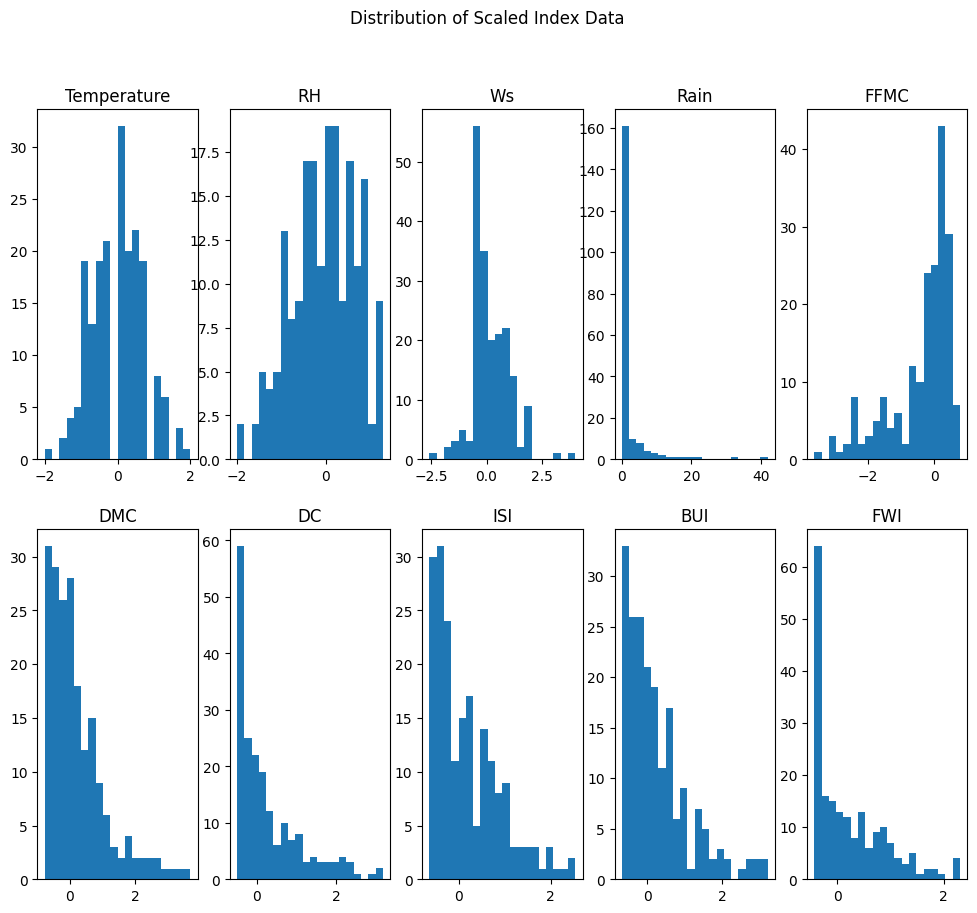

In [167]:
fig, scaled = plt.subplots(2,5, figsize = (12,10))
fig.suptitle('Distribution of Scaled Index Data')
scaled[0,0].hist(s_train.iloc[:,1], bins = 20)
scaled[0,0].set_title('Temperature')
scaled[0,1].hist(s_train.iloc[:,2], bins = 20)
scaled[0,1].set_title('RH')
scaled[0,2].hist(s_train.iloc[:,3], bins = 20)
scaled[0,2].set_title('Ws')
scaled[0,3].hist(s_train.iloc[:,4], bins = 20)
scaled[0,3].set_title('Rain')
scaled[0,4].hist(s_train.iloc[:,5], bins = 20)
scaled[0,4].set_title('FFMC')
scaled[1,0].hist(s_train.iloc[:,6], bins = 20)
scaled[1,0].set_title('DMC')
scaled[1,1].hist(s_train.iloc[:,7], bins = 20)
scaled[1,1].set_title('DC')
scaled[1,2].hist(s_train.iloc[:,8], bins = 20)
scaled[1,2].set_title('ISI')
scaled[1,3].hist(s_train.iloc[:,9], bins = 20)
scaled[1,3].set_title('BUI')
scaled[1,4].hist(s_train.iloc[:,10], bins = 20)
scaled[1,4].set_title('FWI')


With FFWC and DMC both a measure of moisture, maybe rain can be removed since most months have low precipitation, and the moisture content is really what matters for fires. 

Also, looking back at my data understanding, lots of my features are based on calculations of other features.

-FWI is based on ISI and BUI

-BUI is based off of DMC and DC

-ISI is based off of FFMC and WS

So I could try and get rid of WS, FFMC, DC, and DMC-- maybe even ISI and BUI and just keep FWI, temp, RH, and month??? Or just keep the BUI and ISI and get rid of FWI.... or maybe don't use any of their calculations and just keep temp, RH, WS, DMC, DC, and FFMC. If theyre asking to make an improved prediction model, maybe their calculations are missing something that the model could catch. And if i'm going based off of those raw readings, the month may not matter to the model since the fires are based on things like dryness, which may have a trend with month, but the raw readings should see it without the month. So in short, removing all categorical features as well as calculated ones. But I'll keep rain just in case

In [118]:
train_nd.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,month_6,month_7,month_8,month_9,Classes
0,35,42,15,0.3,84.7,15.5,45.1,4.3,16.7,6.3,0,1,0,0,1
1,35,51,13,0.3,81.3,15.6,75.1,2.5,20.7,4.2,0,0,1,0,0
2,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1,0,0,0,1
3,31,68,14,0.0,85.4,12.1,43.1,4.6,14.2,6.0,0,1,0,0,1
4,39,64,9,1.2,73.8,11.7,15.9,1.1,11.4,0.7,0,1,0,0,0


In [119]:
r_train = train_nd.drop(['ISI', 'BUI', 'FWI', 'month_6', 'month_7', 'month_8', 'month_9'], axis=1)

In [120]:
r_train.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,Classes
0,35,42,15,0.3,84.7,15.5,45.1,1
1,35,51,13,0.3,81.3,15.6,75.1,0
2,34,53,18,0.0,89.0,21.6,80.3,1
3,31,68,14,0.0,85.4,12.1,43.1,1
4,39,64,9,1.2,73.8,11.7,15.9,0


# Running the model again

On unscaled data first

In [178]:
Xr = r_train.iloc[:,0:7] 
Xr.head()

yr = r_train.iloc[:,7]
yr.head()
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2)

rfr = RandomForestClassifier()
rfr.fit(Xr_train, yr_train)

yr_pred = rfr.predict(Xr_test)
accuracy_rfr = accuracy_score(yr_test, yr_pred)

print("Accuracy:", accuracy_rfr)
#old accuracy: 0.9743589743589743

Accuracy: 0.9743589743589743


In [122]:
svmr = SVC()
svmr.fit(Xr_train, yr_train) 

yr_pred_svm = svmr.predict(Xr_test)
accuracyr_svm = accuracy_score(yr_test, yr_pred_svm)

print("Accuracy:", accuracyr_svm)
#old accuracy: 0.9230769230769231

Accuracy: 0.8974358974358975


Now scaled

In [123]:
scaled_r_train = scaler.fit_transform(r_train)
rs_train = pd.DataFrame(scaled_r_train)
rs_train.head()

,0,1,2,3,4,5,6,7
0,0.6,-1.000000,0.000000,0.75,0.045752,0.238095,0.166524,0.0
1,0.6,-0.571429,-0.571429,0.75,-0.176471,0.244898,0.681545,-1.0
2,0.4,-0.476190,0.857143,0.00,0.326797,0.653061,0.770815,0.0
3,-0.2,0.238095,-0.285714,0.00,0.091503,0.006803,0.132189,0.0
4,1.4,0.047619,-1.714286,3.00,-0.666667,-0.020408,-0.334764,-1.0


In [183]:
Xrs = rs_train.iloc[:,0:7] 
Xrs.head()

yrs = rs_train.iloc[:,7]
yrs.head()
Xrs_train, Xrs_test, yrs_train, yrs_test = train_test_split(Xrs, yrs, test_size=0.2)

rfrs = RandomForestClassifier()
rfrs.fit(Xrs_train, yrs_train)

yrs_pred = rfrs.predict(Xrs_test)
accuracy_rfrs = accuracy_score(yrs_test, yrs_pred)

print("Accuracy:", accuracy_rfrs)
#previous accuracy: 0.9743589743589743


Accuracy: 0.9743589743589743


In [125]:
svmrs = SVC()
svmrs.fit(Xrs_train, yrs_train) 

yrs_pred_svm = svmrs.predict(Xrs_test)
accuracyrs_svm = accuracy_score(yrs_test, yrs_pred_svm)

print("Accuracy:", accuracyrs_svm)
#previous accuracy: 0.9230769230769231

Accuracy: 0.9487179487179487


Scaling increased the accuracy for SVM to match random forest...

**These results seem to provide evidence that my feature reduction helped with the overfitting. What else can I do?**

# Hyperparameter Tuning

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns

best model:  SVC(C=1.7, gamma='auto')
that models accuracy: 0.9487179487179487
best f1: 0.9352692412342023
classification report for the best model:
               precision    recall  f1-score   support

          -1       0.83      1.00      0.91        10
           0       1.00      0.93      0.96        29

    accuracy                           0.95        39
   macro avg       0.92      0.97      0.94        39
weighted avg       0.96      0.95      0.95        39



<Axes: >

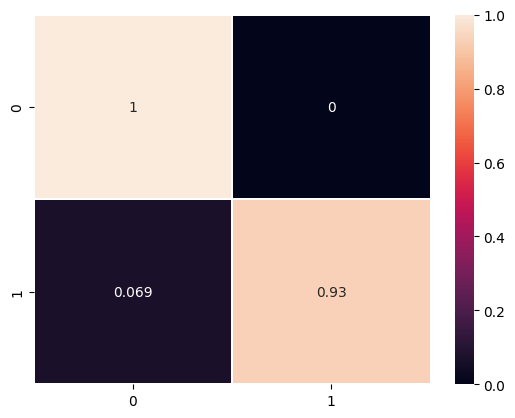

In [254]:
svm_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':[2,1.9,1.8,1.7,1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1, .5, .001], 'gamma':['auto', 'scale']}



grid_search = GridSearchCV(svmrs, svm_parameters, scoring = 'f1_weighted', return_train_score = True, cv = 5)
grid_search.fit(Xrs_train, yrs_train)

best_model = grid_search.best_estimator_
best_f1 = grid_search.best_score_
yrs_pred_best = best_model.predict(Xrs_test)
accuracy_best = accuracy_score(yrs_test, yrs_pred_best)
print('best model: ', best_model)
print('that models accuracy:', accuracy_best)
print('best f1:', best_f1)
print('classification report for the best model:\n', classification_report(yrs_test, yrs_pred_best))

#cm = confusion_matrix(yrs_test, yrs_pred_best)
#sns.heatmap(cm, annot=True, fmt='d')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

Every time I rerun this grid search I get different results even with the same model params...

At first the random forest was predicting high with the unscaled data, with the svm predidcting high on scaled data. Now the've changed. My old accuracy was 97 and f1 was 95 with C=2, auto and linear. That changed to 94 with a false negative- which arent good for fires. I switched to unscaled data on the gridsearch and got a 94 accuracy but a 98 f1, with 2 false positives - but this shows overfitting in the results. 

Now I have a rbf kernel, c = 1.7, gamma = auto,  acc = 94, f1=93, no overfit

**The confusion matrix shows false positives, which is good for forest fire prediction. Better safe than sorry.**

I had to play with C and gamma because it kept favoring a high C, which is prone to overfit. I manually lowered it and got the highest f1 at 2 instead of 1000 or 100 or 5. Gamma also gave more reliable results with auto or scale rather than my manual number inputs. These parameters also kept giving me the same result when rerunning, unlike the others. excess cross validations led to overfit as well, so I stuck to 5.

This link helped me navigate all of that: https://stackabuse.com/understanding-svm-hyperparameters/

In [226]:
#looking to see if there is still overfitting

gs_mean_test_scores = grid_search.cv_results_['mean_test_score']
gs_mean_train_scores = grid_search.cv_results_['mean_train_score']

print("The mean test f1-scores were:", gs_mean_test_scores)
print("The mean train f1-scores were:", gs_mean_train_scores)

The mean test f1-scores were: [0.92885724 0.79691038 0.92883103 0.93431632 0.92885724 0.62696485
 0.92815222 0.88799579 0.92885724 0.79691038 0.92883103 0.9216343
 0.92885724 0.61813416 0.92815222 0.87446566 0.92885724 0.78942202
 0.92883103 0.92160971 0.92885724 0.61813416 0.92146182 0.87438434
 0.92885724 0.78223393 0.93526924 0.92192426 0.92885724 0.61813416
 0.92146182 0.86780859 0.92885724 0.78223393 0.93526924 0.92192426
 0.92885724 0.61813416 0.92146182 0.86780859 0.93516706 0.78223393
 0.93526924 0.91561885 0.93516706 0.60866506 0.92146182 0.86104408
 0.93516706 0.78223393 0.92881763 0.91566398 0.93516706 0.60866506
 0.9149829  0.85365559 0.93516706 0.78223393 0.92881763 0.91540613
 0.93516706 0.60866506 0.90842074 0.85365559 0.92891095 0.78223393
 0.92832284 0.92183846 0.92891095 0.59843021 0.90155346 0.84703952
 0.92260553 0.77474557 0.93475517 0.92183846 0.92260553 0.59843021
 0.90155346 0.84703952 0.92260553 0.77474557 0.92209734 0.92183846
 0.92260553 0.59843021 0.90811562

I'm not seeing a repeat of high mean scores (1), so I'm going to say that the overfitting has been mitigated. 

# Model visualizations

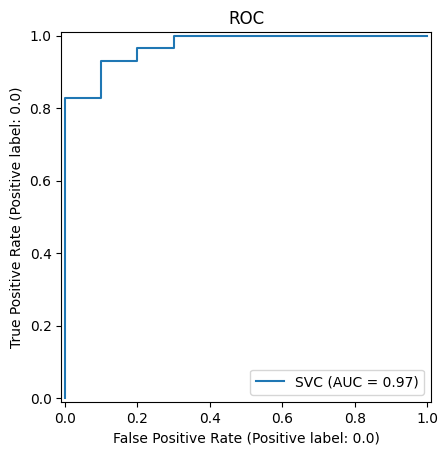

In [268]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
svc_disp = RocCurveDisplay.from_estimator(svmrs, Xrs_test, yrs_test)
plt.title('ROC')
plt.savefig('roc.png')
plt.show()



https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html

# Applying the model to the kaggle test dataset

In [3]:
!pwd
os.chdir('/home/tielyr/Python2/forest-fire-prediction')
!pwd

/home/tielyr/Python2
/home/tielyr/Python2/forest-fire-prediction


In [6]:
!ls
test = pd.read_csv('test.csv')
test.head()

test.csv  train.csv


,ID,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
1,2,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5
2,3,7,6,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2
3,4,6,7,2012,32,63,14,0.0,87.0,10.9,37.0,5.6,12.5,6.8
4,5,10,7,2012,33,69,13,0.7,66.6,6.0,9.3,1.1,5.8,0.5


In [7]:
test.columns

Index(['ID', 'day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ',
       'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'],
      dtype='object')

In [46]:
test_s = test.drop(['ISI', 'BUI', 'FWI', 'day', 'month', 'year', 'ID'], axis=1)
test_s.head()


,Temperature,RH,Ws,Rain,FFMC,DMC,DC
0,29,61,13,1.3,64.4,4.1,7.6
1,27,77,16,0.0,64.8,3.0,14.2
2,33,54,13,0.0,88.2,9.9,30.5
3,32,63,14,0.0,87.0,10.9,37.0
4,33,69,13,0.7,66.6,6.0,9.3


In [47]:
test_s = scaler.fit_transform(test_s)
test_s = pd.DataFrame(test_s)
test_s.head()

,0,1,2,3,4,5,6
0,-0.571429,-0.023810,-0.461538,2.08,-0.901961,-0.288732,-0.417743
1,-0.952381,0.738095,0.461538,0.00,-0.879552,-0.366197,-0.269512
2,0.190476,-0.357143,-0.461538,0.00,0.431373,0.119718,0.096575
3,0.000000,0.071429,-0.153846,0.00,0.364146,0.190141,0.242560
4,0.190476,0.357143,-0.461538,1.12,-0.778711,-0.154930,-0.379562


In [228]:
t_pred_best = best_model.predict(test_s)
print(t_pred_best)

[-1 -1  0  0 -1  0 -1  0 -1  0  0  0  0  0 -1 -1  0 -1 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0 -1]


In [238]:
#making the kaggle submission csv

predictions = list(t_pred_best)
test_predictions = pd.read_csv('test.csv')
test_predictions.head()
test_predictions['Prediction'] = predictions
test_predictions.head()
test_predictions.to_csv('fire_test_preds.csv', index=False)

In [239]:
!ls

fire_test_preds.csv  test.csv  train.csv
